In [1]:
import os, json, sys, time, random
import numpy as np
import torch
from  easydict import EasyDict
from math import floor
from easydict import EasyDict

from steves_utils.vanilla_train_eval_test_jig import  Vanilla_Train_Eval_Test_Jig

from steves_utils.torch_utils import get_dataset_metrics, independent_accuracy_assesment
from steves_models.configurable_vanilla import Configurable_Vanilla
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.lazy_map import Lazy_Map
from steves_utils.sequence_aggregator import Sequence_Aggregator

from steves_utils.stratified_dataset.traditional_accessor import Traditional_Accessor_Factory

from steves_utils.cnn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.torch_utils import (
    confusion_by_domain_over_dataloader,
    independent_accuracy_assesment
)

from steves_utils.utils_v2 import (
    per_domain_accuracy_from_confusion,
    get_datasets_base_path
)

# from steves_utils.ptn_do_report import TBD

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "dataset_seed",
    "seed",
    "labels",
    "domains_target",
    "domains_source",
    "num_examples_per_domain_per_label_source",
    "num_examples_per_domain_per_label_target",
    "batch_size",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "normalize_source",
    "normalize_target",
    "x_net",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "pickle_name_source",
    "pickle_name_target",
    "torch_default_dtype",
}

In [3]:
from steves_utils.ORACLE.utils_v2 import (
    ALL_SERIAL_NUMBERS,
    ALL_DISTANCES_FEET_NARROWED,
)

standalone_parameters = {}
standalone_parameters["experiment_name"] = "MANUAL CORES CNN"
standalone_parameters["lr"] = 0.0001
standalone_parameters["device"] = "cuda"

standalone_parameters["dataset_seed"] = 1337
standalone_parameters["seed"] = 1337
standalone_parameters["labels"] = ALL_SERIAL_NUMBERS

standalone_parameters["domains_source"] = [8,32,50]
standalone_parameters["domains_target"] = [14,20,26,38,44,]

standalone_parameters["num_examples_per_domain_per_label_source"]=-1
standalone_parameters["num_examples_per_domain_per_label_target"]=-1

standalone_parameters["pickle_name_source"] = "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"
standalone_parameters["pickle_name_target"] = "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"

standalone_parameters["torch_default_dtype"] = "torch.float32" 

standalone_parameters["batch_size"]=128

standalone_parameters["n_epoch"] = 3

standalone_parameters["patience"] = 10

standalone_parameters["criteria_for_best"] = "target_accuracy"
standalone_parameters["normalize_source"] = False
standalone_parameters["normalize_target"] = False

standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": len(standalone_parameters["labels"])}},
]

standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"

In [4]:
# Parameters
parameters = {
    "experiment_name": "cnn_1:oracle.run1.framed",
    "labels": [
        "3123D52",
        "3123D65",
        "3123D79",
        "3123D80",
        "3123D54",
        "3123D70",
        "3123D7B",
        "3123D89",
        "3123D58",
        "3123D76",
        "3123D7D",
        "3123EFE",
        "3123D64",
        "3123D78",
        "3123D7E",
        "3124E4A",
    ],
    "domains_source": [8, 32, 50],
    "domains_target": [14, 20, 26, 38, 44],
    "pickle_name_source": "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl",
    "pickle_name_target": "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl",
    "device": "cuda",
    "lr": 0.0001,
    "batch_size": 128,
    "normalize_source": False,
    "normalize_target": False,
    "num_examples_per_domain_per_label_source": -1,
    "num_examples_per_domain_per_label_target": -1,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 16}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "dataset_seed": 500,
    "seed": 500,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")



In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
def wrap_in_dataloader(p, ds):
    return torch.utils.data.DataLoader(
        ds,
        batch_size=p.batch_size,
        shuffle=True,
        num_workers=1,
        persistent_workers=True,
        prefetch_factor=50,
        pin_memory=True
    )

taf_source = Traditional_Accessor_Factory(
    labels=p.labels,
    domains=p.domains_source,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name_source),
    seed=p.dataset_seed
)
train_original_source, val_original_source, test_original_source = \
    taf_source.get_train(), taf_source.get_val(), taf_source.get_test()


taf_target = Traditional_Accessor_Factory(
    labels=p.labels,
    domains=p.domains_target,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name_target),
    seed=p.dataset_seed
)
train_original_target, val_original_target, test_original_target = \
    taf_target.get_train(), taf_target.get_val(), taf_target.get_test()


# For CNN We only use X and Y. And we only train on the source.
# Properly form the data using a transform lambda and Lazy_Map. Finally wrap them in a dataloader

transform_lambda = lambda ex: ex[:2] # Strip the tuple to just (x,y)


train_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(train_original_source, transform_lambda)
)
val_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(val_original_source, transform_lambda)
)
test_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(test_original_source, transform_lambda)
)

train_processed_target = wrap_in_dataloader(
    p,
    Lazy_Map(train_original_target, transform_lambda)
)
val_processed_target = wrap_in_dataloader(
    p,
    Lazy_Map(val_original_target, transform_lambda)
)
test_processed_target  = wrap_in_dataloader(
    p,
    Lazy_Map(test_original_target, transform_lambda)
)



datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [11]:
ep = next(iter(test_processed_target))
ep[0].dtype

torch.float32

In [12]:
model = Configurable_Vanilla(
    x_net=x_net,
    label_loss_object=torch.nn.NLLLoss(),
    learning_rate=p.lr
)

In [13]:
jig = Vanilla_Train_Eval_Test_Jig(
    model=model,
    path_to_best_model=p.BEST_MODEL_PATH,
    device=p.device,
    label_loss_object=torch.nn.NLLLoss(),
)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    patience=p.patience,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    criteria_for_best=p.criteria_for_best
)

epoch: 1, [batch: 1 / 525], examples_per_second: 839.7051, train_label_loss: 2.7724, 


epoch: 1, [batch: 53 / 525], examples_per_second: 10529.1635, train_label_loss: 2.5991, 


epoch: 1, [batch: 105 / 525], examples_per_second: 10778.2804, train_label_loss: 2.4515, 


epoch: 1, [batch: 158 / 525], examples_per_second: 10723.4898, train_label_loss: 2.2268, 


epoch: 1, [batch: 210 / 525], examples_per_second: 10698.8735, train_label_loss: 2.1464, 


epoch: 1, [batch: 263 / 525], examples_per_second: 10641.8623, train_label_loss: 1.9466, 


epoch: 1, [batch: 315 / 525], examples_per_second: 10623.3520, train_label_loss: 1.9340, 


epoch: 1, [batch: 367 / 525], examples_per_second: 10728.8063, train_label_loss: 1.7750, 


epoch: 1, [batch: 420 / 525], examples_per_second: 10650.2908, train_label_loss: 1.7057, 


epoch: 1, [batch: 472 / 525], examples_per_second: 10564.7216, train_label_loss: 1.4749, 


epoch: 1, source_val_acc_label: 0.6501, source_val_label_loss: 1.3592, target_val_acc_label: 0.0775, target_val_label_loss: 5.4089, 


New best
epoch: 2, [batch: 1 / 525], examples_per_second: 100.2233, train_label_loss: 1.2957, 


epoch: 2, [batch: 53 / 525], examples_per_second: 10629.6499, train_label_loss: 1.2961, 


epoch: 2, [batch: 105 / 525], examples_per_second: 10603.6209, train_label_loss: 1.1269, 


epoch: 2, [batch: 158 / 525], examples_per_second: 10711.7908, train_label_loss: 1.0393, 


epoch: 2, [batch: 210 / 525], examples_per_second: 10496.1166, train_label_loss: 1.1202, 


epoch: 2, [batch: 263 / 525], examples_per_second: 10751.7282, train_label_loss: 0.9577, 


epoch: 2, [batch: 315 / 525], examples_per_second: 10558.3526, train_label_loss: 0.9802, 


epoch: 2, [batch: 367 / 525], examples_per_second: 10708.8955, train_label_loss: 0.7666, 


epoch: 2, [batch: 420 / 525], examples_per_second: 10769.7437, train_label_loss: 0.7233, 


epoch: 2, [batch: 472 / 525], examples_per_second: 10727.9653, train_label_loss: 0.7519, 


epoch: 2, source_val_acc_label: 0.8379, source_val_label_loss: 0.7802, target_val_acc_label: 0.0616, target_val_label_loss: 8.4888, 


epoch: 3, [batch: 1 / 525], examples_per_second: 123.3142, train_label_loss: 0.7913, 


epoch: 3, [batch: 53 / 525], examples_per_second: 10711.9732, train_label_loss: 0.7826, 


epoch: 3, [batch: 105 / 525], examples_per_second: 10736.9227, train_label_loss: 0.6861, 


epoch: 3, [batch: 158 / 525], examples_per_second: 10578.4658, train_label_loss: 0.5312, 


epoch: 3, [batch: 210 / 525], examples_per_second: 10602.1149, train_label_loss: 0.6566, 


epoch: 3, [batch: 263 / 525], examples_per_second: 10602.8777, train_label_loss: 0.5316, 


epoch: 3, [batch: 315 / 525], examples_per_second: 10785.8009, train_label_loss: 0.4981, 


epoch: 3, [batch: 367 / 525], examples_per_second: 10798.4586, train_label_loss: 0.4520, 


epoch: 3, [batch: 420 / 525], examples_per_second: 10846.6956, train_label_loss: 0.5141, 


epoch: 3, [batch: 472 / 525], examples_per_second: 10795.7151, train_label_loss: 0.4514, 


epoch: 3, source_val_acc_label: 0.8490, source_val_label_loss: 0.5547, target_val_acc_label: 0.0752, target_val_label_loss: 15.2875, 


epoch: 4, [batch: 1 / 525], examples_per_second: 124.0167, train_label_loss: 0.8212, 


epoch: 4, [batch: 53 / 525], examples_per_second: 10522.8849, train_label_loss: 0.3994, 


epoch: 4, [batch: 105 / 525], examples_per_second: 10739.2852, train_label_loss: 0.3711, 


epoch: 4, [batch: 158 / 525], examples_per_second: 10732.0684, train_label_loss: 0.4424, 


epoch: 4, [batch: 210 / 525], examples_per_second: 10753.9338, train_label_loss: 0.3901, 


epoch: 4, [batch: 263 / 525], examples_per_second: 10753.7071, train_label_loss: 0.4237, 


epoch: 4, [batch: 315 / 525], examples_per_second: 10760.3543, train_label_loss: 0.3312, 


epoch: 4, [batch: 367 / 525], examples_per_second: 10763.8103, train_label_loss: 0.3436, 


epoch: 4, [batch: 420 / 525], examples_per_second: 10690.5372, train_label_loss: 0.3821, 


epoch: 4, [batch: 472 / 525], examples_per_second: 10805.7940, train_label_loss: 0.3451, 


epoch: 4, source_val_acc_label: 0.9195, source_val_label_loss: 0.3509, target_val_acc_label: 0.0776, target_val_label_loss: 19.4227, 


New best
epoch: 5, [batch: 1 / 525], examples_per_second: 122.3236, train_label_loss: 0.3138, 


epoch: 5, [batch: 53 / 525], examples_per_second: 10589.1739, train_label_loss: 0.2777, 


epoch: 5, [batch: 105 / 525], examples_per_second: 10537.2947, train_label_loss: 0.2375, 


epoch: 5, [batch: 158 / 525], examples_per_second: 10594.3900, train_label_loss: 0.3252, 


epoch: 5, [batch: 210 / 525], examples_per_second: 10757.8789, train_label_loss: 0.2872, 


epoch: 5, [batch: 263 / 525], examples_per_second: 10732.7363, train_label_loss: 0.3433, 


epoch: 5, [batch: 315 / 525], examples_per_second: 10724.6106, train_label_loss: 0.3251, 


epoch: 5, [batch: 367 / 525], examples_per_second: 10734.1402, train_label_loss: 0.2595, 


epoch: 5, [batch: 420 / 525], examples_per_second: 10729.9559, train_label_loss: 0.2912, 


epoch: 5, [batch: 472 / 525], examples_per_second: 10722.3122, train_label_loss: 0.2539, 


epoch: 5, source_val_acc_label: 0.8993, source_val_label_loss: 0.3376, target_val_acc_label: 0.0848, target_val_label_loss: 24.9735, 


New best
epoch: 6, [batch: 1 / 525], examples_per_second: 122.8644, train_label_loss: 0.2357, 


epoch: 6, [batch: 53 / 525], examples_per_second: 10590.8410, train_label_loss: 0.2561, 


epoch: 6, [batch: 105 / 525], examples_per_second: 10736.4478, train_label_loss: 0.1689, 


epoch: 6, [batch: 158 / 525], examples_per_second: 10744.0106, train_label_loss: 0.2382, 


epoch: 6, [batch: 210 / 525], examples_per_second: 10741.0330, train_label_loss: 0.2129, 


epoch: 6, [batch: 263 / 525], examples_per_second: 10677.4072, train_label_loss: 0.2475, 


epoch: 6, [batch: 315 / 525], examples_per_second: 10876.2112, train_label_loss: 0.2464, 


epoch: 6, [batch: 367 / 525], examples_per_second: 10836.7832, train_label_loss: 0.2313, 


epoch: 6, [batch: 420 / 525], examples_per_second: 10695.5442, train_label_loss: 0.2644, 


epoch: 6, [batch: 472 / 525], examples_per_second: 10770.6997, train_label_loss: 0.2186, 


epoch: 6, source_val_acc_label: 0.9469, source_val_label_loss: 0.2224, target_val_acc_label: 0.0954, target_val_label_loss: 39.9979, 


New best
epoch: 7, [batch: 1 / 525], examples_per_second: 124.7530, train_label_loss: 0.2419, 


epoch: 7, [batch: 53 / 525], examples_per_second: 10463.9588, train_label_loss: 0.2537, 


epoch: 7, [batch: 105 / 525], examples_per_second: 10544.5184, train_label_loss: 0.2046, 


epoch: 7, [batch: 158 / 525], examples_per_second: 10744.2418, train_label_loss: 0.2359, 


epoch: 7, [batch: 210 / 525], examples_per_second: 10716.0685, train_label_loss: 0.1677, 


epoch: 7, [batch: 263 / 525], examples_per_second: 10751.9435, train_label_loss: 0.1883, 


epoch: 7, [batch: 315 / 525], examples_per_second: 10766.9030, train_label_loss: 0.1985, 


epoch: 7, [batch: 367 / 525], examples_per_second: 10744.3773, train_label_loss: 0.2404, 


epoch: 7, [batch: 420 / 525], examples_per_second: 10748.5481, train_label_loss: 0.1378, 


epoch: 7, [batch: 472 / 525], examples_per_second: 10729.2558, train_label_loss: 0.1322, 


epoch: 7, source_val_acc_label: 0.9227, source_val_label_loss: 0.2429, target_val_acc_label: 0.0945, target_val_label_loss: 22.5213, 


epoch: 8, [batch: 1 / 525], examples_per_second: 126.6378, train_label_loss: 0.1784, 


epoch: 8, [batch: 53 / 525], examples_per_second: 10596.4488, train_label_loss: 0.1684, 


epoch: 8, [batch: 105 / 525], examples_per_second: 10857.3164, train_label_loss: 0.1442, 


epoch: 8, [batch: 158 / 525], examples_per_second: 10717.7017, train_label_loss: 0.2296, 


epoch: 8, [batch: 210 / 525], examples_per_second: 10749.9750, train_label_loss: 0.1313, 


epoch: 8, [batch: 263 / 525], examples_per_second: 10746.5833, train_label_loss: 0.1406, 


epoch: 8, [batch: 315 / 525], examples_per_second: 10753.6894, train_label_loss: 0.2185, 


epoch: 8, [batch: 367 / 525], examples_per_second: 10888.3390, train_label_loss: 0.1425, 


epoch: 8, [batch: 420 / 525], examples_per_second: 10654.2149, train_label_loss: 0.1632, 


epoch: 8, [batch: 472 / 525], examples_per_second: 10766.7078, train_label_loss: 0.2014, 


epoch: 8, source_val_acc_label: 0.9404, source_val_label_loss: 0.2590, target_val_acc_label: 0.1025, target_val_label_loss: 30.5957, 


New best
epoch: 9, [batch: 1 / 525], examples_per_second: 125.6334, train_label_loss: 0.2478, 


epoch: 9, [batch: 53 / 525], examples_per_second: 10710.1403, train_label_loss: 0.2704, 


epoch: 9, [batch: 105 / 525], examples_per_second: 10717.5866, train_label_loss: 0.1615, 


epoch: 9, [batch: 158 / 525], examples_per_second: 10733.5218, train_label_loss: 0.1250, 


epoch: 9, [batch: 210 / 525], examples_per_second: 10798.7719, train_label_loss: 0.2218, 


epoch: 9, [batch: 263 / 525], examples_per_second: 10687.7143, train_label_loss: 0.1410, 


epoch: 9, [batch: 315 / 525], examples_per_second: 10753.3870, train_label_loss: 0.1720, 


epoch: 9, [batch: 367 / 525], examples_per_second: 10763.4492, train_label_loss: 0.1470, 


epoch: 9, [batch: 420 / 525], examples_per_second: 10664.5892, train_label_loss: 0.1410, 


epoch: 9, [batch: 472 / 525], examples_per_second: 10782.2433, train_label_loss: 0.1618, 


epoch: 9, source_val_acc_label: 0.9497, source_val_label_loss: 0.1732, target_val_acc_label: 0.0901, target_val_label_loss: 29.5357, 


epoch: 10, [batch: 1 / 525], examples_per_second: 126.4638, train_label_loss: 0.1076, 


epoch: 10, [batch: 53 / 525], examples_per_second: 10469.4919, train_label_loss: 0.1810, 


epoch: 10, [batch: 105 / 525], examples_per_second: 10796.2119, train_label_loss: 0.1904, 


epoch: 10, [batch: 158 / 525], examples_per_second: 10720.8313, train_label_loss: 0.2348, 


epoch: 10, [batch: 210 / 525], examples_per_second: 10847.3014, train_label_loss: 0.1229, 


epoch: 10, [batch: 263 / 525], examples_per_second: 10637.6292, train_label_loss: 0.1205, 


epoch: 10, [batch: 315 / 525], examples_per_second: 10759.7489, train_label_loss: 0.1899, 


epoch: 10, [batch: 367 / 525], examples_per_second: 10685.7035, train_label_loss: 0.1265, 


epoch: 10, [batch: 420 / 525], examples_per_second: 10812.2677, train_label_loss: 0.1141, 


epoch: 10, [batch: 472 / 525], examples_per_second: 10801.2662, train_label_loss: 0.1586, 


epoch: 10, source_val_acc_label: 0.9196, source_val_label_loss: 0.2777, target_val_acc_label: 0.0903, target_val_label_loss: 41.1357, 


epoch: 11, [batch: 1 / 525], examples_per_second: 126.0622, train_label_loss: 0.1798, 


epoch: 11, [batch: 53 / 525], examples_per_second: 10648.1011, train_label_loss: 0.2763, 


epoch: 11, [batch: 105 / 525], examples_per_second: 10610.8068, train_label_loss: 0.1161, 


epoch: 11, [batch: 158 / 525], examples_per_second: 10586.1206, train_label_loss: 0.2551, 


epoch: 11, [batch: 210 / 525], examples_per_second: 10761.1175, train_label_loss: 0.1188, 


epoch: 11, [batch: 263 / 525], examples_per_second: 10765.0417, train_label_loss: 0.3875, 


epoch: 11, [batch: 315 / 525], examples_per_second: 10733.1497, train_label_loss: 0.1457, 


epoch: 11, [batch: 367 / 525], examples_per_second: 10636.5389, train_label_loss: 0.1958, 


epoch: 11, [batch: 420 / 525], examples_per_second: 10830.8043, train_label_loss: 0.2298, 


epoch: 11, [batch: 472 / 525], examples_per_second: 11957.6505, train_label_loss: 0.1938, 


epoch: 11, source_val_acc_label: 0.9406, source_val_label_loss: 0.2041, target_val_acc_label: 0.1070, target_val_label_loss: 41.3253, 


New best
epoch: 12, [batch: 1 / 525], examples_per_second: 140.0396, train_label_loss: 0.1392, 


epoch: 12, [batch: 53 / 525], examples_per_second: 11813.7309, train_label_loss: 0.1899, 


epoch: 12, [batch: 105 / 525], examples_per_second: 11829.4343, train_label_loss: 0.1242, 


epoch: 12, [batch: 158 / 525], examples_per_second: 11962.8120, train_label_loss: 0.1448, 


epoch: 12, [batch: 210 / 525], examples_per_second: 11724.8145, train_label_loss: 0.1165, 


epoch: 12, [batch: 263 / 525], examples_per_second: 11822.2404, train_label_loss: 0.1094, 


epoch: 12, [batch: 315 / 525], examples_per_second: 11753.5883, train_label_loss: 0.1781, 


epoch: 12, [batch: 367 / 525], examples_per_second: 11839.1966, train_label_loss: 0.1214, 


epoch: 12, [batch: 420 / 525], examples_per_second: 11766.3379, train_label_loss: 0.1500, 


epoch: 12, [batch: 472 / 525], examples_per_second: 11812.5062, train_label_loss: 0.0838, 


epoch: 12, source_val_acc_label: 0.9478, source_val_label_loss: 0.1836, target_val_acc_label: 0.0953, target_val_label_loss: 39.5555, 


epoch: 13, [batch: 1 / 525], examples_per_second: 139.6085, train_label_loss: 0.1255, 


epoch: 13, [batch: 53 / 525], examples_per_second: 11783.9111, train_label_loss: 0.1606, 


epoch: 13, [batch: 105 / 525], examples_per_second: 11798.0891, train_label_loss: 0.1544, 


epoch: 13, [batch: 158 / 525], examples_per_second: 11835.5373, train_label_loss: 0.1153, 


epoch: 13, [batch: 210 / 525], examples_per_second: 11696.6124, train_label_loss: 0.0988, 


epoch: 13, [batch: 263 / 525], examples_per_second: 12194.2334, train_label_loss: 0.1457, 


epoch: 13, [batch: 315 / 525], examples_per_second: 13230.9544, train_label_loss: 0.1185, 


epoch: 13, [batch: 367 / 525], examples_per_second: 13009.7454, train_label_loss: 0.0868, 


epoch: 13, [batch: 420 / 525], examples_per_second: 13913.1702, train_label_loss: 0.0974, 


epoch: 13, [batch: 472 / 525], examples_per_second: 13043.2124, train_label_loss: 0.0829, 


epoch: 13, source_val_acc_label: 0.9516, source_val_label_loss: 0.1529, target_val_acc_label: 0.0988, target_val_label_loss: 44.8561, 


epoch: 14, [batch: 1 / 525], examples_per_second: 157.7453, train_label_loss: 0.0835, 


epoch: 14, [batch: 53 / 525], examples_per_second: 12911.2567, train_label_loss: 0.1266, 


epoch: 14, [batch: 105 / 525], examples_per_second: 13141.4307, train_label_loss: 0.1449, 


epoch: 14, [batch: 158 / 525], examples_per_second: 13041.8789, train_label_loss: 0.1253, 


epoch: 14, [batch: 210 / 525], examples_per_second: 13164.3155, train_label_loss: 0.0889, 


epoch: 14, [batch: 263 / 525], examples_per_second: 13047.5123, train_label_loss: 0.2157, 


epoch: 14, [batch: 315 / 525], examples_per_second: 12560.2937, train_label_loss: 0.1284, 


epoch: 14, [batch: 367 / 525], examples_per_second: 13155.1719, train_label_loss: 0.0959, 


epoch: 14, [batch: 420 / 525], examples_per_second: 13104.6043, train_label_loss: 0.0604, 


epoch: 14, [batch: 472 / 525], examples_per_second: 13055.5642, train_label_loss: 0.1485, 


epoch: 14, source_val_acc_label: 0.9344, source_val_label_loss: 0.1975, target_val_acc_label: 0.0835, target_val_label_loss: 57.3032, 


epoch: 15, [batch: 1 / 525], examples_per_second: 156.3045, train_label_loss: 0.0909, 


epoch: 15, [batch: 53 / 525], examples_per_second: 12347.4988, train_label_loss: 0.1028, 


epoch: 15, [batch: 105 / 525], examples_per_second: 13162.5093, train_label_loss: 0.1717, 


epoch: 15, [batch: 158 / 525], examples_per_second: 12977.5133, train_label_loss: 0.1553, 


epoch: 15, [batch: 210 / 525], examples_per_second: 13715.3000, train_label_loss: 0.1028, 


epoch: 15, [batch: 263 / 525], examples_per_second: 13494.2919, train_label_loss: 0.0543, 


epoch: 15, [batch: 315 / 525], examples_per_second: 12928.4888, train_label_loss: 0.1175, 


epoch: 15, [batch: 367 / 525], examples_per_second: 12889.9984, train_label_loss: 0.1194, 


epoch: 15, [batch: 420 / 525], examples_per_second: 12905.4922, train_label_loss: 0.1169, 


epoch: 15, [batch: 472 / 525], examples_per_second: 12780.3527, train_label_loss: 0.0946, 


epoch: 15, source_val_acc_label: 0.9585, source_val_label_loss: 0.1300, target_val_acc_label: 0.0924, target_val_label_loss: 34.4451, 


Patience (3) exhausted


In [14]:
total_experiment_time_secs = time.time() - start_time_secs

In [15]:
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = wrap_in_dataloader(p, Sequence_Aggregator((datasets.source.original.val, datasets.target.original.val)))

confusion = confusion_by_domain_over_dataloader(model, p.device, val_dl, forward_uses_domain=False)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

###################################
# Write out the results
###################################

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": p,
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "cnn"),
}

<AxesSubplot:title={'center':'Source Train Label Loss vs Source Val Label Loss'}, xlabel='Epoch'>

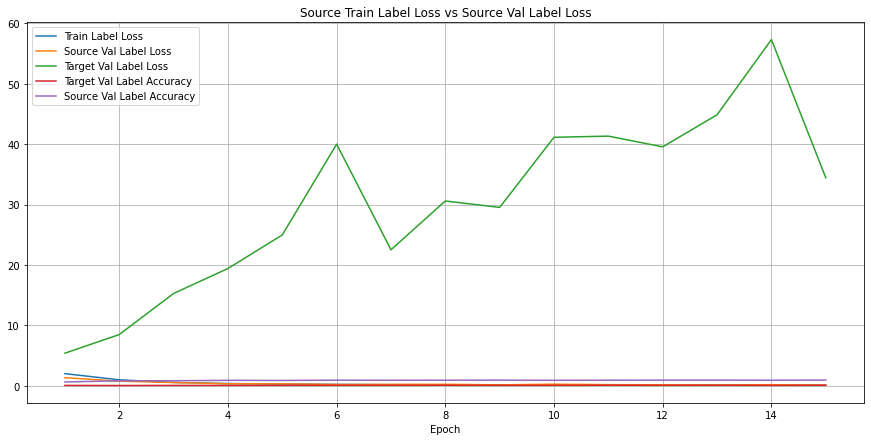

In [16]:
get_loss_curve(experiment)

<AxesSubplot:title={'center':'Results'}>

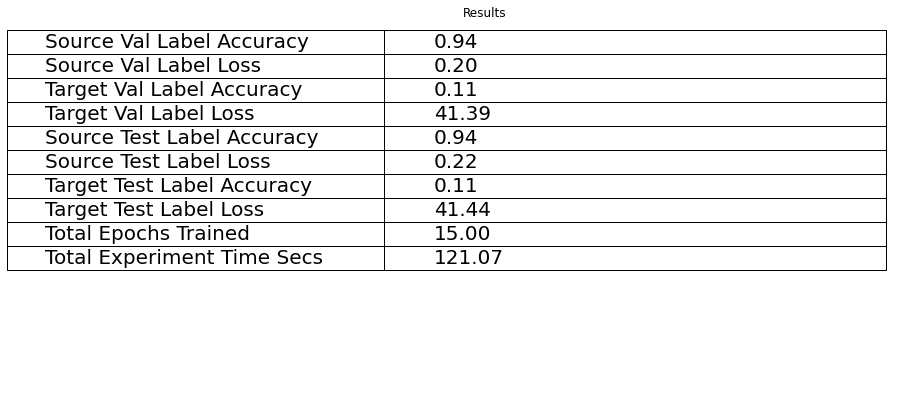

In [17]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Accuracy'}, xlabel='domain'>

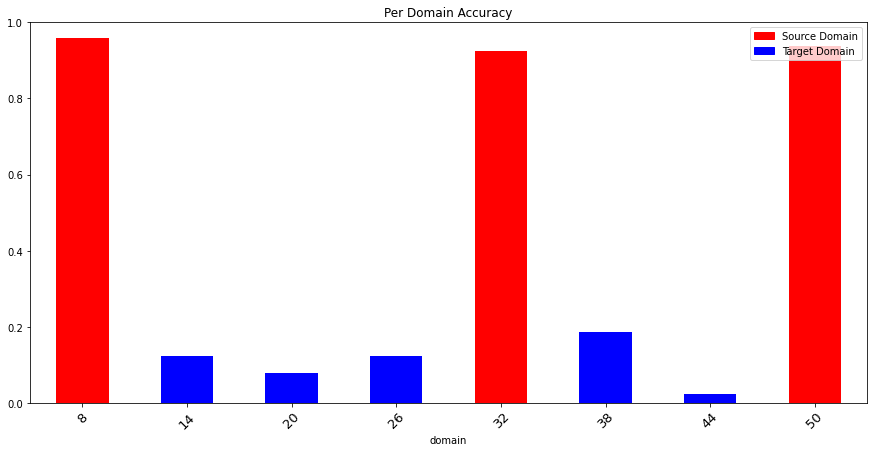

In [18]:
get_domain_accuracies(experiment)

In [19]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.9407638888888888 Target Test Label Accuracy: 0.105875
Source Val Label Accuracy: 0.940625 Target Val Label Accuracy: 0.10695833333333334


In [20]:
json.dumps(experiment)

'{"experiment_name": "cnn_1:oracle.run1.framed", "parameters": {"experiment_name": "cnn_1:oracle.run1.framed", "labels": ["3123D52", "3123D65", "3123D79", "3123D80", "3123D54", "3123D70", "3123D7B", "3123D89", "3123D58", "3123D76", "3123D7D", "3123EFE", "3123D64", "3123D78", "3123D7E", "3124E4A"], "domains_source": [8, 32, 50], "domains_target": [14, 20, 26, 38, 44], "pickle_name_source": "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl", "pickle_name_target": "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl", "device": "cuda", "lr": 0.0001, "batch_size": 128, "normalize_source": false, "normalize_target": false, "num_examples_per_domain_per_label_source": -1, "num_examples_per_domain_per_label_target": -1, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_accuracy", "x_net": [{"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}}, {"class": "Conv2d", "kargs": {"in_channels": 1, "out_channels": 256, "kernel_size": [1